# Grover's Search Algorithm
This algorithm attempts to find an element in an unordered list faster than is possible classically.

## Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.tools.jupyter import *
#IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()

## Oracle Circuit
This circuit creates a matrix where the diagonal from left to right is 1 and the marked element along this diagonal is -1. Every other value in the matrix is 0. This will be our encoding for the oracle for the algorithm. Note, in pracitice the inner workings of the oracle will be unknown, the point is to try and extract information from the blackbox without opening it.

In [2]:
def phase_oracle(n, indices):
    qc = QuantumCircuit(n, name='Oracle')
    oracle_matrix = np.identity(2**n)
    
    for i in indices:
        oracle_matrix[i, i] = -1
    
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

## Diffuser Circuit
The function of this circuit is to perform the necessary rotations to shift the quantum state of our qubits towards the marked element. The initial state $s$ is reflected such that the quantum state after the diffuser is $s' = 2|s><s|-1$.

In [2]:
def diffuser(n):
    qc = QuantumCircuit(n, name='Diffuser')
    
    for qubit in range(n):
        qc.h(qubit)
        qc.x(qubit)
    
    qc.barrier()
    
    # Multi-controlled-Z gate
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)  # multi-controlled-toffoli
    qc.h(n-1)
    
    qc.barrier()
    
    for qubit in range(n):
        qc.x(qubit)
        qc.h(qubit)    
    
    return qc

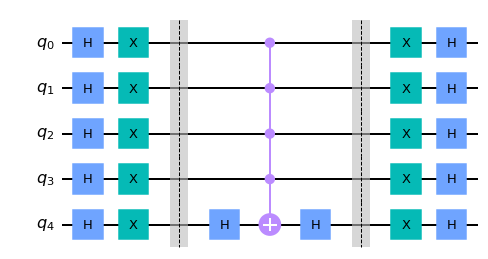

In [3]:
n = 5
qc = diffuser(n)
qc.draw(output='mpl')

## Grover's Algorithm Circuit
All the qubits are put into a state of superposition and then put through the oracle and then the diffuser gates $r$ times to estimate the marked element. This calculation can be shown below.

In [4]:
def Grover(n, marked):
    qc = QuantumCircuit(n, n)
    r = int(np.round(np.pi/(4*np.arcsin(np.sqrt(len(marked)/2**n)))-1/2)) #number of phase and diffuser rounds
    
    print(f'{n} qubits, index {marked} marked, {r} reflections')
    
    qc.h(range(n))
    
    for _ in range(r):
        qc.append(phase_oracle(n, marked), range(n))
        qc.append(diffuser(n), range(n))
    
    qc.measure(range(n), range(n))
    
    return qc

5 qubits, index [0] marked, 4 reflections


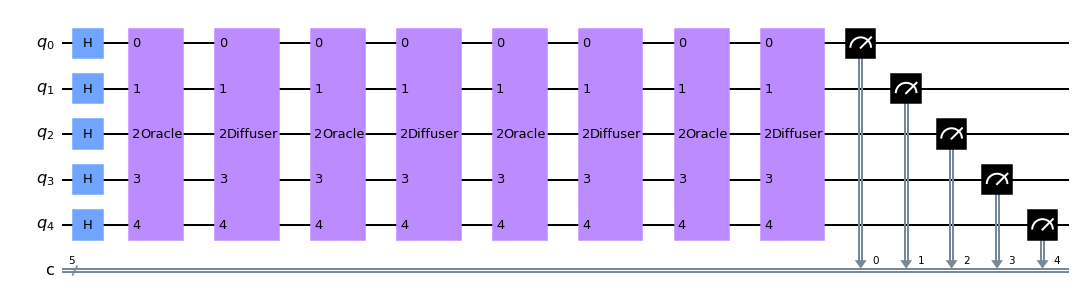

In [5]:
n = 5
x = np.random.randint(2**n) # marked element
qc = Grover(n, [x])

qc.draw(output='mpl')

## Simulating the Algorithm
Grover's algorithm can find the marked element with almost certainty under ideal circumstances. The reason the marked index is not 100% guaranteed is because the number of reflections $r$ is rounded up because you cannot possibly have a fraction of a reflection. This can result in over compensation in amplitude amplication that causes error in a small number of shots.

5 qubits, index [19] marked, 4 reflections


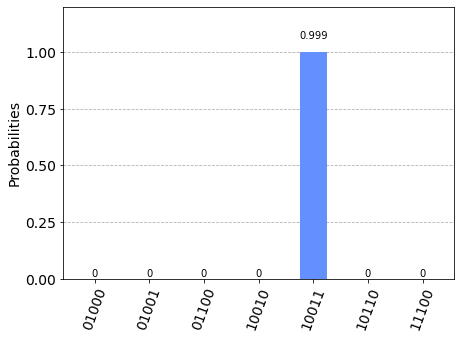

In [6]:
n = 5
x = np.random.randint(2**n) # marked element
qc = Grover(n, [x])

sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 10000).result()
counts = result.get_counts()
plot_histogram(counts)

## Execution in Reality
Errors and noise become too much for Grover's algorithm to find an element with a five-bit index. However it is still possible to find an element, or even two elements, with a three-bit index number. This means that Grover's algorithm can work with lists that are seven elements in length with no problem but lists that are 31 elements long can't be searched with this algorithm unless more error correction techniques are applied.

In [11]:
n = 5
x = np.random.randint(2**n) # marked element
qc = Grover(n, [x])

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

5 qubits, basis state [20] marked, 4 rounds
Least busy:  ibmq_belem


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

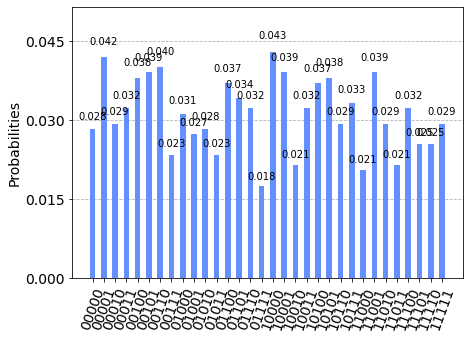

In [12]:
counts = job.result().get_counts()
plot_histogram(counts)

In [13]:
n = 3
x = np.random.randint(2**n) # marked element
qc = Grover(n, [x])

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

3 qubits, basis state [6] marked, 2 rounds
Least busy:  ibmq_belem


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

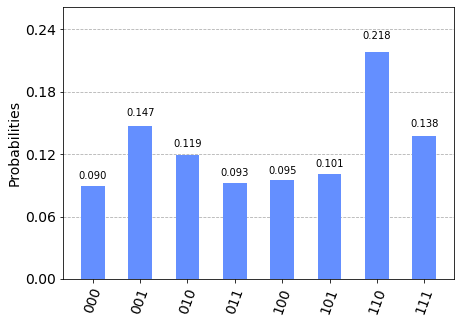

In [14]:
counts = job.result().get_counts()
plot_histogram(counts)

In [7]:
n = 3

x = np.random.randint(2**n)
y = np.random.randint(2**n)

while x == y:
    y = np.random.randint(2**n)
    
marked = [x, y]
qc = Grover(n, marked)

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and
                                      not x.configuration().simulator and x.status().operational==True))

print("Least busy: ", backend)

%qiskit_job_watcher

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

3 qubits, index [4, 2] marked, 1 reflections
Least busy:  ibmq_quito


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

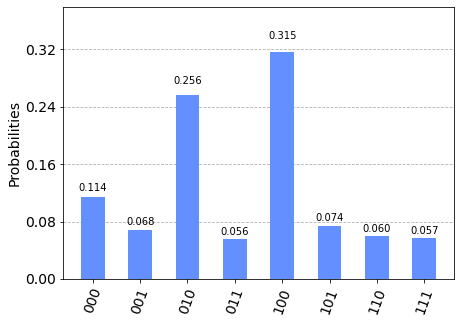

In [8]:
counts = job.result().get_counts()
plot_histogram(counts)